In [2]:
import os, sys, pickle
%pylab inline
plt.style.use("default")

Populating the interactive namespace from numpy and matplotlib


In [465]:
prefix = "gamp6_sd0.5exactly_n2000_exp2__"
#prefix = "model_osn_data_gamp6_sd0.5exactly_n200__"
#prefix = "gamp5_exp1__"
suffix = "seed0"
#prefix = "model_osn_data_two_pulse_multiple_amps_gamp5__"
#prefix = "gamp5_exp1__"
#prefix = "gamp5_sd0.5_exp1__"
#prefix = "model_osn_data_gamp6_sd0.5exactly_n200__"

files = {"conc":f"{prefix}conc_orig_{suffix}.p",
         "conc_shuf":f"{prefix}conc_shuf_{suffix}.p",
         "delay.conc":f"{prefix}delay.conc_orig_{suffix}.p",
         "delay.conc_shuf":f"{prefix}delay.conc_shuf_{suffix}.p"
}
def load_file(f):
    with open(f,"rb") as ff:
        return pickle.load(ff)

data = {fld:load_file(fl) for fld, fl in files.items()}

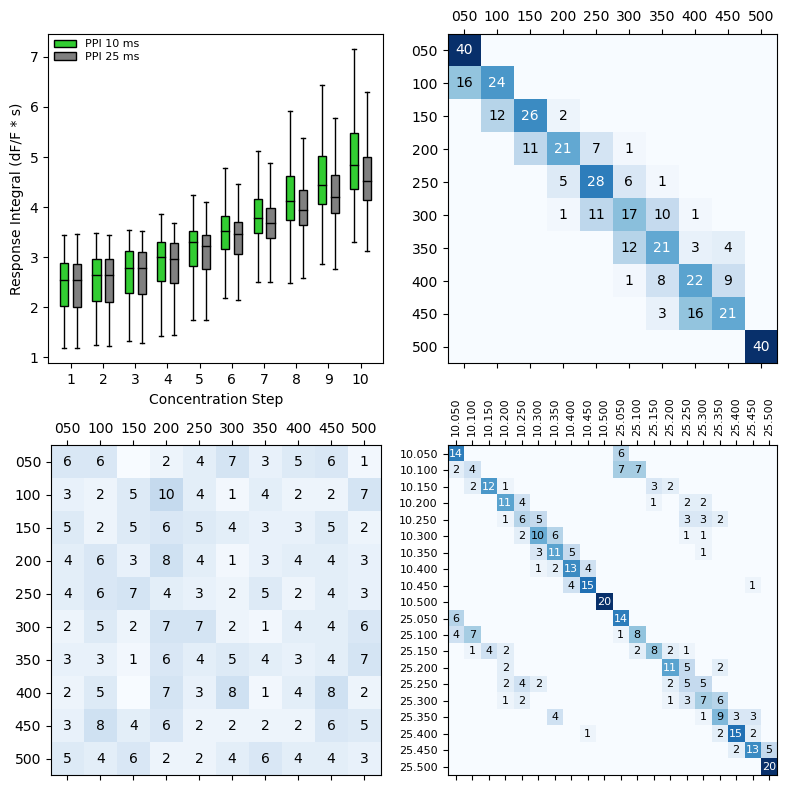

In [466]:
figure(figsize=(8,8))
subplot(2,2,1)
concs = data["conc"]["labels"]
delay_concs = data["delay.conc"]["labels"]
X     = data["delay.conc"]["X"]
y     = data["delay.conc"]["y"]
resps = {10:array([X[array(y)==f"10.{int(c):03d}"].flatten() for c in concs]).T,
         25:array([X[array(y)==f"25.{int(c):03d}"].flatten() for c in concs]).T}
concs = sorted(list(set(yi.split(".")[1] for yi in y)))
centers= arange(len(concs))
bplots = []
for (ppi, color, offset) in [(10, "limegreen", -0.2), (25, "gray", 0.2)]:
    pos   = centers + offset
    bplots.append(boxplot(resps[ppi], showfliers=False, patch_artist = True, medianprops={"color":"black", "linewidth":1}, positions=pos, widths=0.25))
    [b.set_facecolor(color) for b in bplots[-1]["boxes"]]
gca().set_xticks(centers)
gca().set_xticklabels(arange(1,len(concs)+1))
xlabel("Concentration Step"); ylabel("Response Integral (dF/F * s)")
#gca().set_yticks(arange(0,5))
legend([bp["boxes"][0] for bp in bplots],["PPI 10 ms", "PPI 25 ms"], loc="upper left", fontsize=8, labelspacing=0.25,frameon=False, borderpad=0)

# Now the confusion matrix for concentration
cm_conc   = data["conc"]["confusion_matrix"]
label_cm  = lambda cm,th,fsz=10: [text(j,i,cm[i,j],fontsize=fsz,verticalalignment="center", horizontalalignment="center", color="w" if cm[i,j] > th else "k") if cm[i,j] else [] for j in range(cm.shape[1]) for i in range(cm.shape[0])]
set_ticks = lambda labs: [(ticks_fun(arange(len(labs))), tickslabel_fun(labs)) for (ticks_fun, tickslabel_fun) in [(gca().set_xticks, gca().set_xticklabels), (gca().set_yticks, gca().set_yticklabels)]]
subplot(2,2,2); matshow(data["conc"]["confusion_matrix"],       fignum=False, cmap=cm.Blues, vmin=0, vmax=sum(cm_conc[0])); label_cm(data["conc"]["confusion_matrix"], 20); set_ticks(concs);
subplot(2,2,3); matshow(data["conc_shuf"]["confusion_matrix"],  fignum=False, cmap=cm.Blues, vmin=0, vmax=sum(cm_conc[0])); label_cm(data["conc_shuf"]["confusion_matrix"], 20); set_ticks(concs);
subplot(2,2,4); matshow(data["delay.conc"]["confusion_matrix"], fignum=False, cmap=cm.Blues); label_cm(data["delay.conc"]["confusion_matrix"], 10, 8)
gca().set_xticks(arange(len(delay_concs))); gca().set_xticklabels(delay_concs,fontsize=8, rotation=90)
gca().set_yticks(arange(len(delay_concs))); gca().set_yticklabels(delay_concs,fontsize=8)
tight_layout()

# Let's look at the data

In [467]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn import svm
from importlib import reload
reload(svm)
LinearSVC = svm.LinearSVC
from sklearn.linear_model import RidgeClassifierCV

dict_keys([('pSgS!', 0.5), ('pSgS!', 1.0), ('pSgS!', 1.5), ('pSgS!', 2.0), ('pSgS!', 2.5), ('pSgS!', 3.0), ('pSgS!', 3.5), ('pSgS!', 4.0), ('pSgS!', 4.5), ('pSgS!', 5.0), ('pShS!', 0.5), ('pShS!', 1.0), ('pShS!', 1.5), ('pShS!', 2.0), ('pShS!', 2.5), ('pShS!', 3.0), ('pShS!', 3.5), ('pShS!', 4.0), ('pShS!', 4.5), ('pShS!', 5.0)])


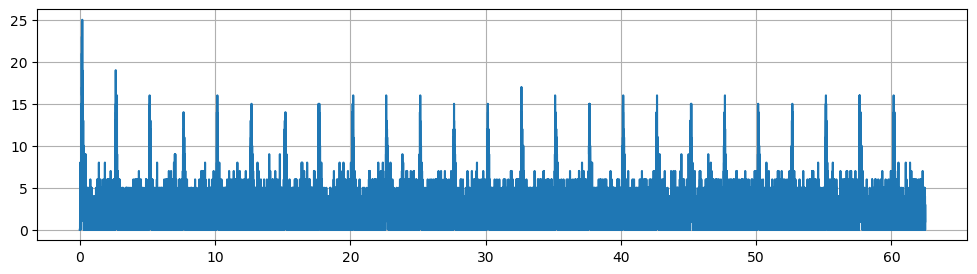

In [468]:
data_dir = "model_osn_data_two_pulse_multiple_amps_gamp5" #"model_osn_data_gamp5"
counts = np.load(os.path.join(data_dir, "params1", "counts.p"), allow_pickle = True)
print(counts.keys())
times  = np.load(os.path.join(data_dir, "params1", "t.p"), allow_pickle = True)
figure(figsize=(12,3))
k = ('pSgS!', 1.5)
plot(times[k[0]], counts[k])
#xlim(20,30)
grid(True)

In [469]:
suffix

'seed0'

In [470]:
#with open((input_file := f"{prefix}conc_shuf_{suffix}.input.p"), "rb") as f:
#    print(input_file)
#    data = pickle.load(f)
X = data["conc_shuf"]["X"]
y = data["conc_shuf"]["y"]

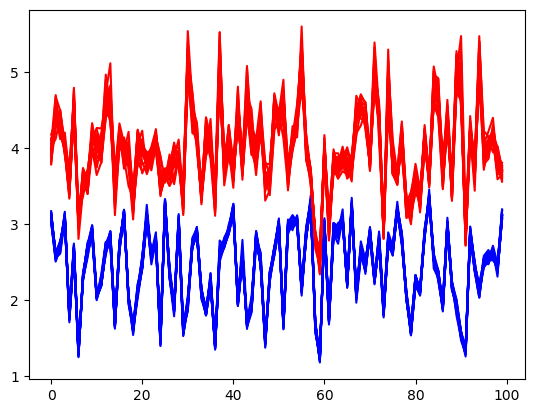

In [471]:
plot(X[:20].T,"b")
plot(X[-60:-40].T,"r")

In [472]:
corrcoef(X)

array([[ 1.        ,  0.99358812,  0.99224013, ..., -0.2358443 ,
        -0.25347644, -0.25103276],
       [ 0.99358812,  1.        ,  0.99499883, ..., -0.22907117,
        -0.25054307, -0.25405676],
       [ 0.99224013,  0.99499883,  1.        , ..., -0.23984144,
        -0.25891327, -0.26139434],
       ...,
       [-0.2358443 , -0.22907117, -0.23984144, ...,  1.        ,
         0.96620664,  0.94247023],
       [-0.25347644, -0.25054307, -0.25891327, ...,  0.96620664,
         1.        ,  0.95131502],
       [-0.25103276, -0.25405676, -0.26139434, ...,  0.94247023,
         0.95131502,  1.        ]])

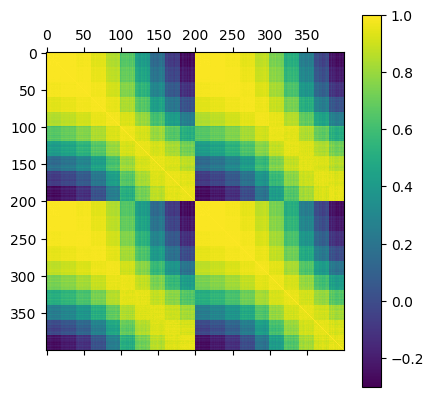

In [473]:
matshow(corrcoef(X)); colorbar()

In [483]:
XX = copy(X)
yy = copy(y)
#XX = array([[cos(th + rand()*2*pi/100), sin(th + rand()*2*pi/100)] + [0]*98 for th in list(arange(10)/10*2*pi)*2 for i in range(20)])
#XX = randn(*XX.shape)*std(XX)
#XX = outer(randn(XX.shape[0],), rand(XX.shape[1],)) + 0*randn(*XX.shape)*1e-3
seed = 0
np.random.seed(seed)
n_cv = 10
sss = StratifiedShuffleSplit(n_splits = n_cv, random_state = seed)
indices = [(train_index, test_index) for (train_index, test_index) in sss.split(XX,yy)]

labels   = sorted(np.unique(y), key=float)
n_labels = len(labels)
    
confusion_matrix = np.zeros((n_labels, n_labels)).astype(int)
C_vals = [10**i for i in range(-8,6,1)]
alphas = [1/C for C in C_vals]

use_ridge = False
fit_intercept = False
if not use_ridge:
    search = GridSearchCV(LinearSVC(penalty="l2", dual=False, max_iter = 100000),
                          {"C":C_vals, "fit_intercept":[fit_intercept]})                     
else:
    search = GridSearchCV(RidgeClassifierCV(alphas = alphas), {"fit_intercept":[fit_intercept]})                     

#X = StandardScaler().fit_transform(X.T).T
#X = StandardScaler().fit_transform(X)

format_val = lambda val: str(val) if type(val) not in [float] else f"{val:>7.3e}"

shuf = True
acc = []
X_trn_arr, y_trn_arr = [], []
X_tst_arr, y_tst_arr = [], []
for icv, (train_index, test_index) in enumerate(sss.split(XX,yy)):
    train_index = sorted(train_index)
    test_index  = sorted(test_index)
    X_trn, y_trn = XX[train_index], [yy[i] for i in train_index]
    X_tst, y_tst = XX[test_index],  [yy[i] for i in test_index]
    if shuf:
        y_trn = np.random.permutation(y_trn)
        y_tst = np.random.permutation(y_tst)

    search.fit(X_trn, y_trn)
    yp = search.predict(X_tst)
    acc.append(np.mean(yp==y_tst))
    best_params_str = " ".join([f"{fld:>12s}={format_val(val):<5s}" for fld,val  in search.best_params_.items()])
    if use_ridge:
        best_params_str = f"alpha={search.best_estimator_.alpha_:1.3f}" + best_params_str
    print(f"{best_params_str:>40s}: {acc[-1]:>1.3f}")


    cm1 = 0* confusion_matrix
    for y_true, y_pred in zip(y_tst, yp):
        cm1[labels.index(y_true), labels.index(y_pred)] += 1
    print(cm1)
    confusion_matrix+= cm1
    #ConnectionRefusedErrorconfusion_matrix[labels.index(yi), labels.index(yp[i])] += 1

    X_trn_arr.append(X_trn)
    X_tst_arr.append(X_tst)
    y_trn_arr.append(y_trn)
    y_tst_arr.append(y_tst)

           C=1.000e-04 fit_intercept=False: 0.100
[[0 0 0 0 0 0 0 0 0 4]
 [0 0 0 0 0 0 0 0 0 4]
 [0 0 0 0 0 0 0 0 0 4]
 [0 0 0 0 0 0 0 0 0 4]
 [0 0 0 0 0 0 0 0 0 4]
 [0 0 0 0 0 0 0 0 0 4]
 [0 0 0 0 0 0 0 0 0 4]
 [0 0 0 0 0 0 0 0 0 4]
 [0 0 0 0 0 0 0 0 0 4]
 [0 0 0 0 0 0 0 0 0 4]]


           C=1.000e-04 fit_intercept=False: 0.100
[[0 0 4 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]]


           C=1.000e-05 fit_intercept=False: 0.100
[[0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]]


             C=10    fit_intercept=False: 0.050
[[0 1 0 2 0 0 0 0 0 1]
 [0 0 0 1 1 0 2 0 0 0]
 [0 1 0 0 0 0 1 1 1 0]
 [1 0 1 0 0 0 0 1 0 1]
 [0 2 1 0 0 0 1 0 0 0]
 [0 2 1 1 0 0 0 0 0 0]
 [0 0 2 1 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 1 0 2]
 [0 0 0 0 0 1 0 1 1 1]
 [0 0 0 0 1 1 1 1 0 0]]


           C=1.000e-02 fit_intercept=False: 0.075
[[0 0 3 0 0 0 1 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 1 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 1 0 0]
 [0 0 3 0 0 0 1 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 1 0 0 0]]


           C=1.000e-08 fit_intercept=False: 0.100
[[0 4 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 3 0 0 0]
 [0 2 0 0 0 0 2 0 0 0]
 [0 1 0 0 0 0 3 0 0 0]
 [0 2 0 0 0 0 2 0 0 0]
 [0 3 0 0 0 0 1 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 2 0 0 0]
 [0 2 0 0 0 0 2 0 0 0]]


           C=1.000e-03 fit_intercept=False: 0.100
[[0 4 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]]


             C=10    fit_intercept=False: 0.075
[[0 0 1 0 1 0 1 0 1 0]
 [1 0 0 0 0 0 0 1 1 1]
 [0 0 1 0 0 0 1 1 1 0]
 [1 1 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 1 0 1 1 0]
 [1 0 0 0 1 0 1 0 1 0]
 [1 1 0 0 0 0 1 0 1 0]
 [0 0 0 2 1 0 0 1 0 0]
 [0 1 0 0 0 1 1 1 0 0]
 [0 1 0 0 1 1 0 1 0 0]]


             C=1000  fit_intercept=False: 0.175
[[1 1 0 1 0 1 0 0 0 0]
 [1 1 0 0 0 0 1 1 0 0]
 [0 1 0 0 1 1 0 1 0 0]
 [0 0 0 2 1 0 0 0 0 1]
 [1 2 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 2 1 0]
 [0 0 0 0 0 0 1 2 0 1]
 [0 0 1 0 0 1 0 1 0 1]
 [2 1 0 0 0 0 0 0 1 0]
 [0 0 0 2 1 0 1 0 0 0]]


           C=1.000e-06 fit_intercept=False: 0.100
[[0 3 0 0 1 0 0 0 0 0]
 [0 2 0 0 2 0 0 0 0 0]
 [0 1 0 0 3 0 0 0 0 0]
 [0 1 0 0 2 1 0 0 0 0]
 [0 2 0 0 2 0 0 0 0 0]
 [0 1 0 0 3 0 0 0 0 0]
 [0 1 0 0 1 2 0 0 0 0]
 [0 2 0 0 1 1 0 0 0 0]
 [0 1 0 0 3 0 0 0 0 0]
 [0 0 0 0 2 2 0 0 0 0]]


           C=1.000e-05 fit_intercept=False: acc=0.100
[[0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]]


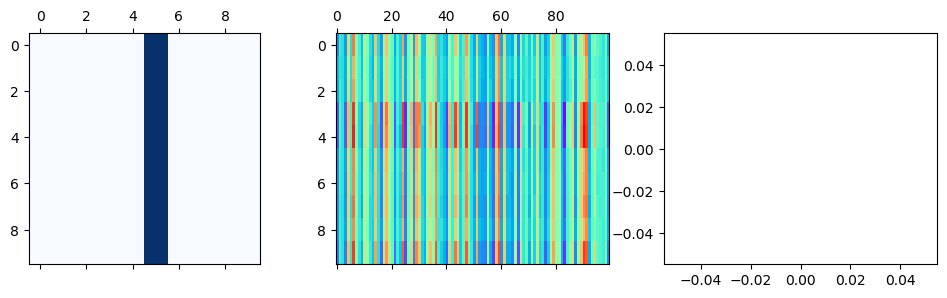

In [490]:
which_index = 2
X_trn, y_trn = X_trn_arr[which_index], y_trn_arr[which_index]
X_tst, y_tst = X_tst_arr[which_index], y_tst_arr[which_index]
search.fit(X_trn, y_trn)
yp = search.predict(X_tst)
acc.append(np.mean(yp==y_tst))
best_params_str = " ".join([f"{fld:>12s}={format_val(val):<5s}" for fld,val  in search.best_params_.items()])
print(f"{best_params_str:>40s}: acc={acc[-1]:>1.3f}")

cm1 = 0 * confusion_matrix
for y_true, y_pred in zip(y_tst, yp):
    cm1[labels.index(y_true), labels.index(y_pred)] += 1
print(cm1)
#confusion_matrix+= cm1
figure(figsize=(12,3))
subplot(1,3,1); matshow(cm1, fignum=False, cmap=cm.Blues)
subplot(1,3,2); matshow(search.best_estimator_.coef_, fignum=False, cmap=cm.rainbow); axis("auto")
subplot(1,3,3); plot(search.best_estimator_.intercept_)

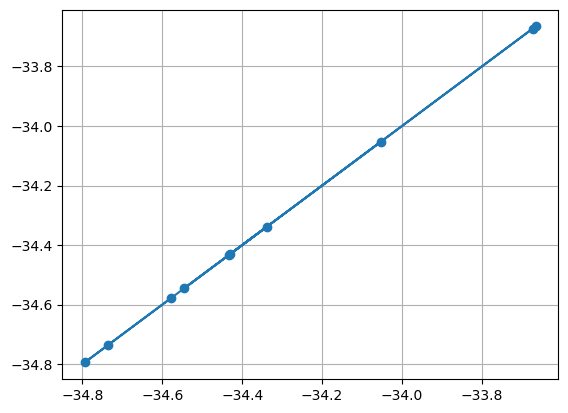

In [491]:
coef = search.best_estimator_.coef_
coefn= coef / norm(coef,axis=1)[:,np.newaxis]
z    = X_tst @ coef.T
d    = X_tst @ coefn.T + search.best_estimator_.intercept_
df   = search.best_estimator_.decision_function(X_tst)
plot(d[10],df[10],"o-"); grid(True)

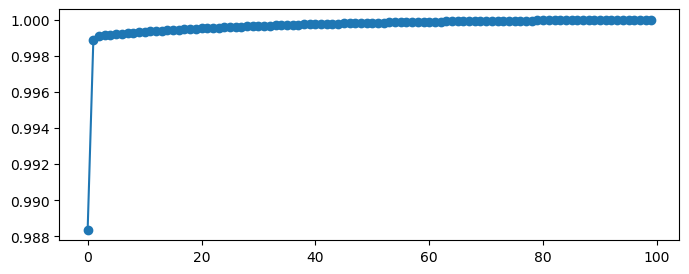

In [492]:
X1 = copy(X_trn)
y1 = copy(y_trn)
labs = sorted(unique(y1), key=int)
U1,S1,V1t = linalg.svd(X1, full_matrices=False)
figure(figsize=(8,3))
plot(cumsum(S1**2)/sum(S1**2), "o-")

In [493]:
US1 = U1 @ diag(S1)
print(norm(US1 @ V1t - X1))
X1e = US1[:, :2] @ V1t[:2]
X1tste = X_tst @ V1t[:2].T
coefse = V1t[:2] @ search.best_estimator_.coef_.T
print(norm(X1 - X1e)**2/norm(X1)**2)

6.136289734770385e-13
0.0011049342154277433


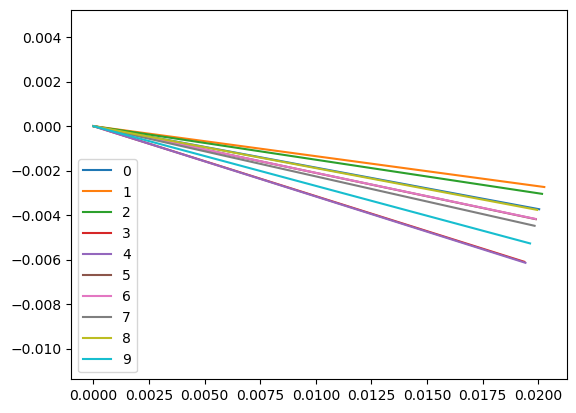

In [494]:
xxx=array([0*coefse[0], coefse[0]])
yyy=array([0*coefse[1], coefse[1]])
for i in range(xx.shape[1]):
    plot(xxx[:,i],yyy[:,i],label=str(i))
axis("equal")
legend()

0.9988951405198158


Text(0.5, 1.05, 'Test: 0.100')

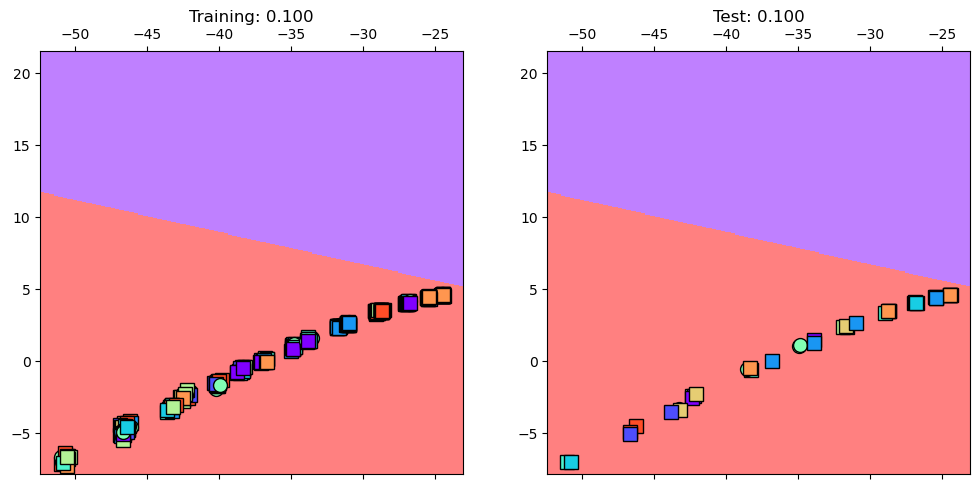

In [495]:
figure(figsize=(12,12))
clf = search.best_estimator_
y_trn_pred = clf.predict(X_trn)
y_tst_pred = clf.predict(X_tst)
UU,SS,VVt = linalg.svd(XX, full_matrices=False)
print(sum(SS[:2]**2)/sum(SS**2))
US = UU @ diag(SS)
labs = sorted(unique(yy), key=int)
subplot(2,2,1)
for i in range(US.shape[0]):
    plot(US[i,0],US[i,1], "o", markersize=3, color=cm.rainbow(labs.index(yy[i])/float(len(labs))))
axis("square")
xl = xlim(); xr = linspace(xl[0],xl[1],401)
yl = ylim(); yr = linspace(yl[0],yl[1],401)
xm, ym = meshgrid(xr, yr)
pm = VVt[:2].T @ [xm.flatten(), ym.flatten()]
zm = array([labs.index(i) for i in clf.predict(pm.T)])
zm = zm.reshape(xm.shape)

#subplot(2,2,2)
#cc = copy(clf.coef_)
#cc /= norm(cc,axis=1)[:, np.newaxis]
#ccc = cc @ VVt[:2].T
#for i, cci in enumerate(ccc):
#    plot([0,cci[0]], [0, cci[1]], color=cm.rainbow(i/float(len(labs))), linewidth=1)
gcf().clf()
subplot(1,2,1)
#contourf(xm,ym,zm,levels=10, cmap=cm.rainbow, alpha=0.5)
matshow(zm, origin="lower", extent=[xl[0],xl[1],yl[0],yl[1]], cmap=cm.rainbow, alpha=0.5, fignum=False)
Ptrn = X_trn @ VVt[:2].T
for i in range(Ptrn.shape[0]):
    plot(Ptrn[i,0], Ptrn[i,1], "o" if y_trn_pred[i] == y_trn[i] else "s", markersize=10, markeredgecolor="k", color=cm.rainbow(labs.index(y_trn[i])/float(len(labs))))
xlim(xl); ylim(yl);
title(f"Training: {mean(y_trn_pred==y_trn):1.3f}")

subplot(1,2,2)
#contourf(xm,ym,zm, levels=10, cmap=cm.rainbow, alpha=0.5)
matshow(zm, origin="lower", extent=[xl[0],xl[1],yl[0],yl[1]], cmap=cm.rainbow, alpha=0.5, fignum=False)
Ptst = X_tst @ VVt[:2].T
for i in range(Ptst.shape[0]):
    plot(Ptst[i,0], Ptst[i,1], "o" if y_tst_pred[i] == y_tst[i] else "s", markersize=10, markeredgecolor="k", color=cm.rainbow(labs.index(y_tst[i])/float(len(labs))))
xlim(xl); ylim(yl);
title(f"Test: {mean(y_tst_pred==y_tst):1.3f}")